# Application of _QuantumRandomWalks_ Python package
### Historical Quantum Link Prediction

This code applies the __QuantumRandomWalks__ Pythonpackage to perform link prediction on one historical citation network which can be found here: [here](https://hernandezj1.github.io/ThesisWebsite1/pdf/fullfullfinal.pdf). A walk starting from a single node and a walk starting from the superposition of all nodes were performed.

## Imports

In [1]:

from QuantumRandomWalks.QRW import *
from QuantumRandomWalks.post_processing import *
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

## Network import and pre-processing

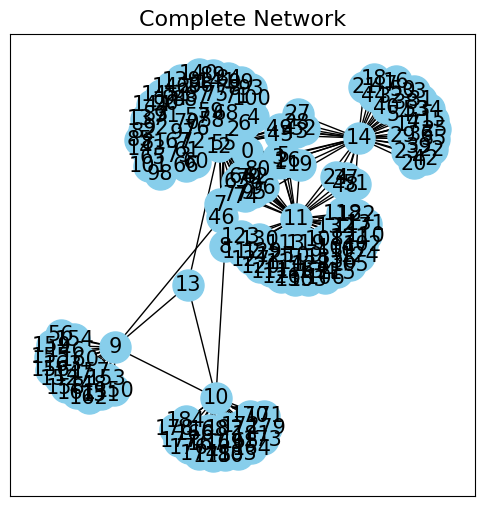

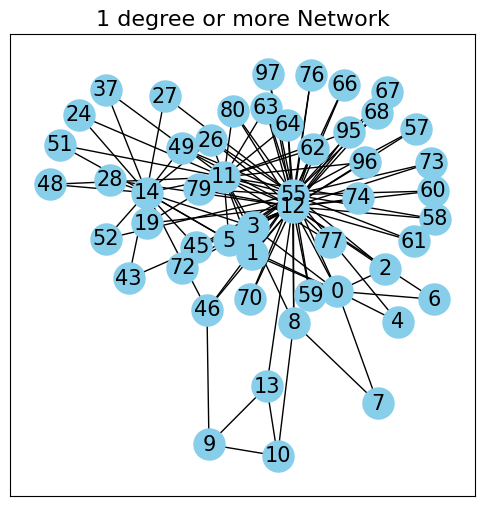

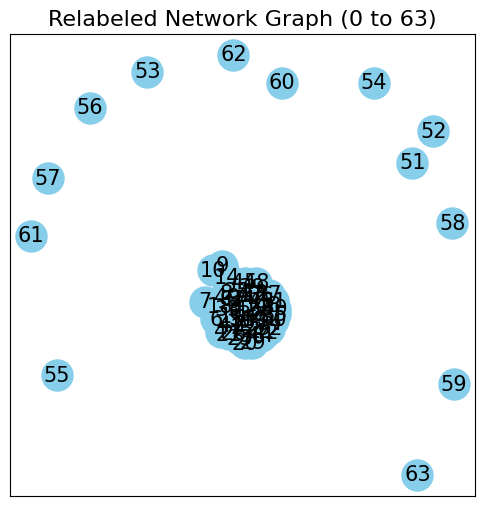

In [ ]:


# Loading the CSV of the network
csv_path = "complete-citation-network.csv" 
df = pd.read_csv(csv_path)

# We create the edges given the Gephi export structure of target and Source columns in the CSV
edges = list(zip(df['Source'], df['Target']))

# We assemble the graph from the created edges 
G = nx.Graph()  
G.add_edges_from(edges)

# plotting of original network
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Complete Network", fontsize=16)
plt.show()


# Remove nodes with degree 0 or 1
# This step si crucila because our walker can become very skewed when dealing with chokepoints in our graph also this lets us minimze the network to a managable size
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree <= 1]
G.remove_nodes_from(nodes_to_remove)

# Plotting after connection removal
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("1 degree or more Network", fontsize=16)
plt.show()

# It is necessary for the total amount of ndoes to be a power of 2
# In our case the closest power of 2 is 64 so we will add unconnected nodes to fill our matrix
current_num_nodes = G.number_of_nodes()
additional_nodes_needed = 64 - current_num_nodes


# The following code block adds those nodes
if additional_nodes_needed > 0:
    max_node_id = max(G.nodes) if len(G.nodes) > 0 else -1
    new_nodes = range(max_node_id + 1, max_node_id + 1 + additional_nodes_needed)
    G.add_nodes_from(new_nodes)

# Relabel nodes to range from 0 to 63 for ease of undertsaidng in the results dataframe
old_to_new_mapping = {old_id: new_id for new_id, old_id in enumerate(G.nodes())}
G = nx.relabel_nodes(G, old_to_new_mapping)

# Create a table mapping old IDs to new IDs so we can retrace what edges are actually being predicted when we compare to our old table
mapping_table = pd.DataFrame(list(old_to_new_mapping.items()), columns=["Old ID", "New ID"])
mapping_table.to_csv("node_mapping_table.csv", index=False)



# Plot the final graph
# This can and SHOULD be done at intermediate spots to see the actual graph connections
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Relabeled Network Graph (0 to 63)", fontsize=16)
plt.show()

Now we will convert our network graph to an adjacency matrix that represent each connection with a 1 in the approrpiiate row and column corresponding to each source and target node.

In [4]:

adj_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(adj_matrix)

A = adj_matrix.astype(float)

Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Quantum circuit creation

Here is where we will use our __QuantumRandomWalks__ library.  First we will do a walk starting at node 9, one of our nodes of interest and then we will do a walk starting at all nodes to observe all possible edge predictions.

In this section we will create the qauntum circuits for a specific time stamp in its evolution so we can see what our networks look like. The next section will produce the walk results for multiple times in a single dataframe. 

### Single node walk circuit

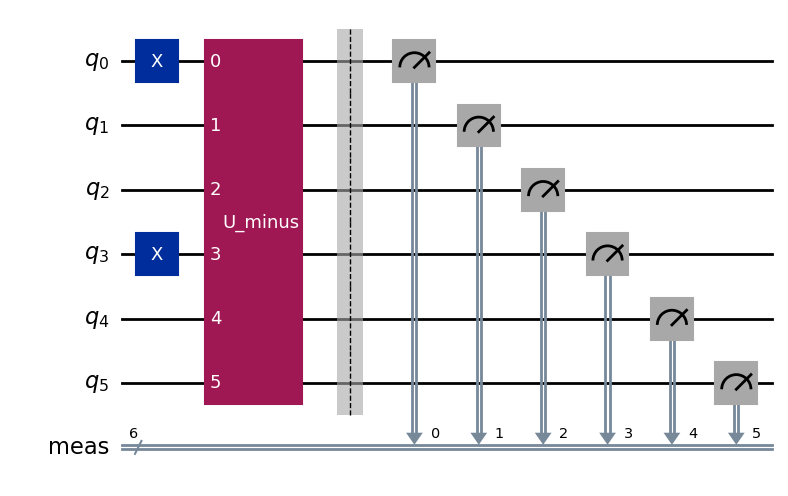

In [5]:
qrw = QuantumRandomWalk(A) # We create a walk from the matrix we produced
qrw.start_node_n(9) # Specifying which start node to be used
qrw.walk_out(1)   # This specificies a sepecifc time for the unitary operator
qrw.complete_single_node() # Adds measurements and appropriate labels
qrw._qc.draw("mpl")

### Superpositioned walk circuit

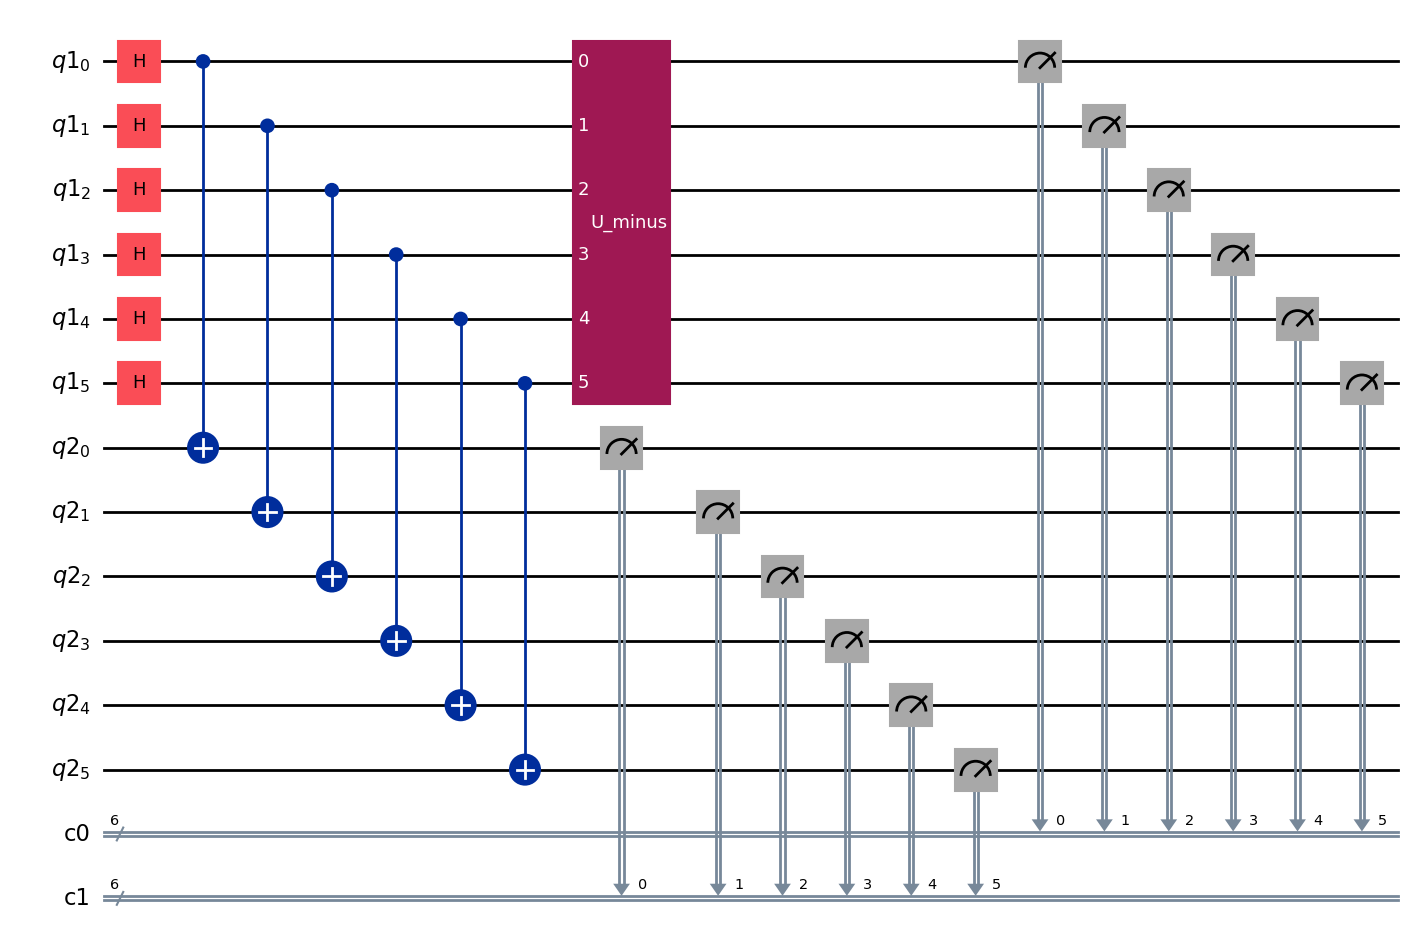

In [6]:
qrw2=QuantumRandomWalk(A) # creates our circuit based on the size of our adjacency matrix
qrw2.superposition() # puts them in superposition, which means we add the H and CNOT gates
qrw2.walk_out(1)  # specifies if the walk is in or our into the nodes
qrw2.complete_superposition() # completes measurements and classical register divisions
qrw2._qc.draw("mpl")

Below we can see a results of the simulator for all of the possible edges with our superpositioned walk

In [7]:
qrw2.simulator_measure('aer_simulator')
print(qrw2._counts)

{'101000 101000': 14, '110010 110010': 16, '001110 001010': 5, '010100 010100': 5, '010111 001001': 1, '010001 001110': 1, '000100 000100': 5, '000000 000101': 2, '100011 100110': 1, '001101 011110': 4, '011111 011111': 18, '001111 101110': 1, '011100 011110': 1, '001010 000111': 2, '110000 001111': 1, '101110 101110': 13, '111100 111100': 20, '010110 010110': 10, '111001 111001': 19, '101111 101111': 10, '101001 100111': 1, '110101 110101': 13, '100110 100110': 14, '011010 010000': 1, '001011 001011': 7, '101001 011110': 1, '010000 000011': 1, '000110 000110': 4, '001101 000111': 1, '100011 100011': 18, '011011 011011': 8, '000000 000000': 4, '010101 110000': 1, '001111 001111': 14, '000100 010001': 2, '011111 010000': 1, '010000 010000': 11, '001101 001101': 4, '110001 110001': 13, '101100 101100': 17, '101010 101010': 14, '001010 001010': 1, '010011 010011': 19, '110011 110011': 18, '110000 110000': 9, '010001 011010': 1, '000010 000101': 1, '001010 001110': 8, '100001 100001': 8, '

## Run quantum walk

All quantum walks are simulated given that our network is of 64 nodes. hardware limits wil be explained in the paper but as summary: 

- Current IBM circuit-based hardware can only handle about 5000 2-qubit gates. Our 64 node example produces about ~17,000-20,000 gates when transpiled due to its unitary initizialization. But this is cut down to ~8000-9000 when using the Rz fractional gates which are abilitated on some of the Heron QPU. Even then given the limit of 5000 2-qubit gates for decoherence our walks can only be performed for 1,2,4,8,16, and 32 node networks for now.

### Run single node quantum walk
Now we can perform our single-node quantum walk at appropriate time stamps

In [8]:
# Quantum walk starting at node 9 for 10 time units with 0.5 time increments
df_complete = perform_one_node_walk(A,9,'out',10,0.5) 
print(df_complete)

    Time         0         1         2         3         4         5  \
0    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.5  0.000000  0.001953  0.000000  0.000977  0.000000  0.000000   
2    1.0  0.000000  0.004883  0.000000  0.000000  0.002930  0.000000   
3    1.5  0.004883  0.006836  0.001953  0.002930  0.015625  0.004883   
4    2.0  0.004883  0.000000  0.003906  0.005859  0.024414  0.005859   
5    2.5  0.003906  0.004883  0.002930  0.004883  0.001953  0.006836   
6    3.0  0.001953  0.011719  0.000977  0.000000  0.001953  0.000000   
7    3.5  0.000000  0.000977  0.001953  0.000977  0.005859  0.000000   
8    4.0  0.000000  0.005859  0.000000  0.000000  0.000000  0.000000   
9    4.5  0.005859  0.011719  0.003906  0.000000  0.002930  0.000977   
10   5.0  0.007812  0.000977  0.013672  0.011719  0.032227  0.011719   
11   5.5  0.007812  0.035156  0.002930  0.004883  0.012695  0.006836   
12   6.0  0.000000  0.041016  0.000000  0.000977  0.000000  0.00

In [9]:
# Post-processing and saving
df_processed = ResultsDataframe(df_complete).postprocess_one_node()  
df_complete.to_csv('start_at_node9_walk.csv', index= False)

### Run superpositioned quantum walk

In [10]:
# Superpositoned walk with 10 time units and 0.5 time increments
df_complete = perform_superpositioned_walk(A,'out',10,0.5) 
df_processed = ResultsDataframe(df_complete)

# Post-Processing and Saving
df_processed = df_processed.postprocess_superposition(A)
df_processed.df.to_csv('superposition_walk.csv', index=False)
